## Imports

In [1]:
import MDAnalysis as mda
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from MDAnalysis.lib.distances import distance_array
from MDAnalysis import units
from MDAnalysis.analysis import rdf
from openmm.unit import AVOGADRO_CONSTANT_NA, BOLTZMANN_CONSTANT_kB
from openmm.unit import kelvin, bar, litre, kilojoule_per_mole, mole, nanometer, angstrom, kilocalorie_per_mole
from openmm.unit import Quantity, Unit
import quantities
from matplotlib import colors
from matplotlib.ticker import PercentFormatter
from pymbar import timeseries
from MDAnalysis.analysis import density
from tqdm import tqdm


/tmp/ipykernel_7715/123884183.py:3: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd
Warning on use of the timeseries module: If the inherent timescales of the system are long compared to those being analyzed, this statistical inefficiency may be an underestimate.  The estimate presumes the use of many statistically independent samples.  Tests should be performed to assess whether this condition is satisfied.   Be cautious in the interpretation of the data.

****** PyMBAR will use 64-bit JAX! *******
* JAX is currently set to 32-bit bitsize *
* which is its default.                  *
*               

## Loading data and creating atom group of ions

In [2]:
u = mda.Universe('md.gro', 'md.xtc')
u.transfer_to_memory()
ions= u.select_atoms('resname NA CL')

u1 = mda.Universe('mdr1.gro', 'mdr1.xtc')
u1.transfer_to_memory()
ions1= u1.select_atoms('resname NA CL')

u2 = mda.Universe('mdr2.gro', 'mdr2.xtc')
u2.transfer_to_memory()
ions2= u2.select_atoms('resname NA CL')

u3 = mda.Universe('mdr3.gro', 'mdr3.xtc')
u3.transfer_to_memory()
ions3= u3.select_atoms('resname NA CL')




## Function for calculating osmotic values:

In [9]:
def SPW_analysis(u, ions, repnum):

## loading data
        
    if repnum == 0:
        print("Data for original run")
    else:
        print("Data for replicate #",repnum)

    box_size = u.dimensions[:3] * angstrom
    wall1=box_size[2]/2-24*angstrom
    wall2=box_size[2]/2+24*angstrom
    R = BOLTZMANN_CONSTANT_kB * AVOGADRO_CONSTANT_NA # gas constant
    
    box_x = box_size[0]
    box_y = box_size[1]

    A_box = (box_x * box_y)

    dim_mem = wall2-wall1
    V_mem = A_box * dim_mem
    #print(V_mem)

    n_part = 65
    M = n_part / (V_mem * AVOGADRO_CONSTANT_NA)
    M = M.in_units_of(mole / litre)
    #print(M)

## calculation of osmotic values

    def osmotic_values(mean_force_wall, molarity :Quantity, vant_hoff : int=2, T=300*kelvin, cross_sectional_area : Quantity=48*48 * angstrom**2 ):
        osm_press=mean_force_wall/cross_sectional_area
        osm_bar = osm_press.in_units_of(bar / mole)
        osm_bar = osm_bar/AVOGADRO_CONSTANT_NA
        print(f"Osmotic Pressure Observed:", osm_bar)
        osm_press_ideal=vant_hoff*molarity*R*T
        osm_press_ideal=osm_press_ideal.in_units_of(bar)
        print(f"Osmotic Pressure Ideal:", osm_press_ideal)
        osm_coeff=osm_bar/osm_press_ideal
        print(f"Osmotic Coefficient:", osm_coeff)

        return osm_bar, osm_coeff
    
    def osmotic_values_noprint(mean_force_wall, molarity=M, vant_hoff:int=2, T=300*kelvin, cross_sectional_area:Quantity=(wall1*wall2)):
        osm_press=mean_force_wall/cross_sectional_area
        osm_bar = osm_press.in_units_of(bar / mole)
        osm_bar = osm_bar/AVOGADRO_CONSTANT_NA
        osm_press_ideal=vant_hoff*molarity*R*T
        osm_press_ideal=osm_press_ideal.in_units_of(bar)
        osm_coeff=osm_bar/osm_press_ideal
        op_error=(abs(osm_bar-osm_press_ideal)/osm_press_ideal)*100
        return osm_bar,osm_coeff

    def calculate_net_force(z_values : np.ndarray[float], zwall : float, k : float) -> float:
        return k * abs(z_values - zwall).sum()

## calculation of mean force

    k_nm = 4184 * kilojoule_per_mole / nanometer**2
    k = k_nm.in_units_of(kilojoule_per_mole / angstrom**2)

    walls_z_pos = np.array([48, 96]) * angstrom
    forces_at_ts = {
        48 : [],
        96 : []
    }

    for _ in u.trajectory:
        ions_z = ions.positions[:,2]*angstrom
        force_48 = calculate_net_force(
            z_values=ions_z[ions_z < wall1],
            zwall=wall1,
            k=k
        )
        forces_at_ts[48].append(force_48)

        force_96 = calculate_net_force(
            z_values=ions_z[ions_z > wall2],
            zwall=wall2,
            k=k
        )
        forces_at_ts[96].append(force_96)

    mean_forces = {
        abs_wall_z : sum(force_list, start=0*(kilojoule_per_mole / angstrom)) / len(u.trajectory)
            for abs_wall_z, force_list in forces_at_ts.items()
    }

    print('mean forces =', mean_forces)



## calling calculation of osmotic values
    
    for wall_z_val, mF in mean_forces.items():
        print(wall_z_val)
        o = osmotic_values(mF, molarity=M, cross_sectional_area=A_box)


    print("\nAverage between 2 walls: ")
    av_mF=(mean_forces[48]+mean_forces[96])/2
    o = osmotic_values(av_mF, molarity=M, cross_sectional_area=A_box)

## number of ions per z coordinate (both observed through the system and outside the walls)
    ions_at_48=[]
    ions_at_96=[]
    zpositions=[]

    for _ in u.trajectory:
        ions_z = ions.positions[:,2]*angstrom
        zpositions.append(ions_z)
        z_values48=ions_z[ions_z < wall1]
        z_values96=ions_z[ions_z > wall2]
        ions_at_48.append(z_values48)
        ions_at_96.append(z_values96)

    # plt.hist(ions_at_48,bins='auto',edgecolor='blue')
    # plt.xlabel('z coordinates (A)')
    # plt.ylabel('Number of Ions')
    # plt.title('Number of ions outside of wall at 4.8 nm')
    # plt.axis([47, 48, 0, 2.5])
    # # Display the plot
    # plt.grid(True)
    # plt.show()

    # plt.hist(ions_at_96,bins='auto',edgecolor='red')
    # plt.xlabel('z coordinates (A)')
    # plt.ylabel('Number of Ions')
    # plt.title('Number of ions outside of wall at 9.6 nm')
    # plt.axis([96, 97, 0, 2.5])
    # plt.grid(True)
    # plt.show()

    # plt.hist(zpositions,bins='auto',edgecolor='green')
    # plt.xlabel('z coordinates (A)')
    # plt.ylabel('Number of Ions')
    # plt.title('Number of ions per z coordinate')
    # plt.grid(True)
    # plt.show()

## plotting force vs time

    list48=forces_at_ts[48]
    list96=forces_at_ts[96]
    f48=[]
    f96=[]
    time=[]
    for i,ts in enumerate(u.trajectory):
        time.append(u.trajectory.time)
        val48=list48[i]
        val96=list96[i]
        f48.append(val48.item())
        f96.append(val96.item())

    plt.plot(time,f96, color='r', label='9.6 nm')
    plt.plot(time,f48, color='g', label='4.8 nm')
    plt.ylabel("Forces")
    plt.xlabel("Time")
    plt.title("Forces vs time")
    plt.legend()
    plt.show()


## calculation of autocorrelation function and plot of uncorrelated samples
    
    fts48=np.array(f48)
    fts96=np.array(f96)

    nskip=100
    t0, g, Neff_max = timeseries.detect_equilibration(fts48,nskip=nskip) # compute indices of uncorrelated timeseries
    fts48_equil = fts48[t0:]
    indices48 = timeseries.subsample_correlated_data(fts48_equil, g=g)
    fts48_s = fts48_equil[indices48]

    indt48=[]
    for i in indices48:
        indt48.append(time[i])

    print('t0 =', t0,' g =',g,' Neff_max =', Neff_max)

    plt.plot(time,f48)
    plt.scatter(indt48, fts48_s, color='m', marker='o')
    plt.ylabel("Forces")
    plt.xlabel("Time")
    plt.title("Forces at 4.8 nm Wall")
    plt.show()

    t0, g, Neff_max = timeseries.detect_equilibration(fts96,nskip=nskip) # compute indices of uncorrelated timeseries
    fts96_equil = fts96[t0:]
    indices96 = timeseries.subsample_correlated_data(fts96_equil, g=g)
    fts96_s = fts96_equil[indices96]

    indt96=[]
    for i in indices96:
        indt96.append(time[i])

    print('t0 =', t0,' g =',g,' Neff_max =', Neff_max)


    plt.plot(time, f96, c='g')
    plt.scatter(indt96, fts96_s, color='m', marker='o')
    plt.ylabel("Forces")
    plt.xlabel("Time")
    plt.title("Forces at 9.6 nm Wall")
    plt.show()

    print("----------------------------------------------------------------")

## calculation of autocorrelation function and plot of uncorrelated samples
    
    fts48=np.array(f48)
    fts96=np.array(f96)

    nskip=100
    t0, g, Neff_max = timeseries.detect_equilibration(fts48,nskip=nskip) # compute indices of uncorrelated timeseries
    fts48_equil = fts48[t0:]
    indices48 = timeseries.subsample_correlated_data(fts48_equil, g=g)
    fts48_s = fts48_equil[indices48]

    indt48=[]
    for i in indices48:
        indt48.append(time[i])

    print("---Wall 4.8 nm---")
    print('t0 =', t0,' g =',g,' Neff_max =', Neff_max)
    #mean of full time series
    meanf48=np.mean(f48)
    meanf48=meanf48*kilojoule_per_mole/angstrom
    #stdev of the full timeseries devided by sqrt of the number of effective samples -1
    sterrf48=np.std(f48)/np.sqrt(len(indt48)-1)
    # squared_diff48 = (f48*kilojoule_per_mole/angstrom - meanf48) ** 2
    varf48 = sterrf48**2

    print(f"Mean = {meanf48}, std error = {sterrf48}, variance = {varf48}",'\n')

    # plt.plot(time,f48)
    # plt.scatter(indt48, fts48_s, color='m', marker='o')
    # plt.ylabel("Forces")
    # plt.xlabel("Time")
    # plt.title("Forces at 4.8 nm Wall")
    # plt.show()

    t0, g, Neff_max = timeseries.detect_equilibration(fts96,nskip=nskip) # compute indices of uncorrelated timeseries
    fts96_equil = fts96[t0:]
    indices96 = timeseries.subsample_correlated_data(fts96_equil, g=g)
    fts96_s = fts96_equil[indices96]

    indt96=[]
    for i in indices96:
        indt96.append(time[i])


    print("---Wall 9.6 nm---")
    #statistical values of t0 (time after equil), g (statistical efficiency/correlation time of equil data), Neff (# of eff samples)
    print('t0 =', t0,' g =',g,' Neff_max =', Neff_max)
    #mean of full time series
    meanf96=np.mean(f96)
    meanf96=meanf96*mF.unit
    #stdev of the full timeseries devided by sqrt of the number of effective samples -1
    sterrf96=np.std(f96)/np.sqrt(len(indt96)-1)
    # squared_diff96 = (f96*kilojoule_per_mole/angstrom - meanf96) ** 2
    varf96 = sterrf96**2
    print(f"Mean = {meanf96}, std error = {sterrf96}, variance = {varf96}",'\n')

    # plt.plot(time, f96, c='g')
    # plt.scatter(indt96, fts96_s, color='m', marker='o')
    # plt.ylabel("Forces")
    # plt.xlabel("Time")
    # plt.title("Forces at 9.6 nm Wall")
    # plt.show()

    def comb_SEM(sem1,sem2,n1,n2):
        """
        Calculate the standard error of the mean for combined data.

        Args:
        sem1 (float): Standard error of the mean for the first set of data.
        sem2 (float): Standard error of the mean for the second set of data.
        n1 (int): Sample size of the first set of data.
        n2 (int): Sample size of the second set of data.

        Returns:
        float: The standard error of the mean for combined data.
        """
        combined_sem = np.sqrt((sem1**2 * (n1 - 1) + sem2**2 * (n2 - 1)) / (n1 + n2 - 2))
        return combined_sem
    
    print("---Statistical Analysis results---")
    #average between two walls
    statmeanF=(meanf48+meanf96)/2
    errvar=np.sqrt((varf48+varf96)/2)
    comberror=comb_SEM(sterrf48,sterrf96,len(indt48),len(indt96))
    print(f'Mean force between two walls: {statmeanF}')
    print(f'Mean std error between two walls: +/-{comberror} or {errvar}')
    
    errvar=errvar*(kilojoule_per_mole/angstrom)
    print("------------------------------------------------------------------------")

    print(f"FINAL STATISTICAL RESULTS:")
    
    print("------------------------------------------------------------------------")   
    #calculation of osmotic values from statistical mean and std error
    osmval = osmotic_values_noprint(statmeanF, molarity=M, cross_sectional_area=A_box) 
    osmerr = osmotic_values_noprint(errvar, molarity=M, cross_sectional_area=A_box)

    print(f"Osmotic Pressure = {osmval[0]} +/- {osmerr[0]} \nOsmotic Coefficient = {osmval[1]} +/- {osmerr[1]}")

    return osmval[0],osmerr[0]

Data for original run
mean forces = {48: Quantity(value=4.818444512945548, unit=kilojoule/(angstrom*mole)), 96: Quantity(value=5.304747068117462, unit=kilojoule/(angstrom*mole))}
48
Osmotic Pressure Observed: 34.727497208140356 bar
Osmotic Pressure Ideal: 48.688251410590276 bar
Osmotic Coefficient: 0.7132623621103532
96
Osmotic Pressure Observed: 38.23237737884101 bar
Osmotic Pressure Ideal: 48.688251410590276 bar
Osmotic Coefficient: 0.7852485203550565

Average between 2 walls: 
Osmotic Pressure Observed: 36.47993729349068 bar
Osmotic Pressure Ideal: 48.688251410590276 bar
Osmotic Coefficient: 0.7492554412327048


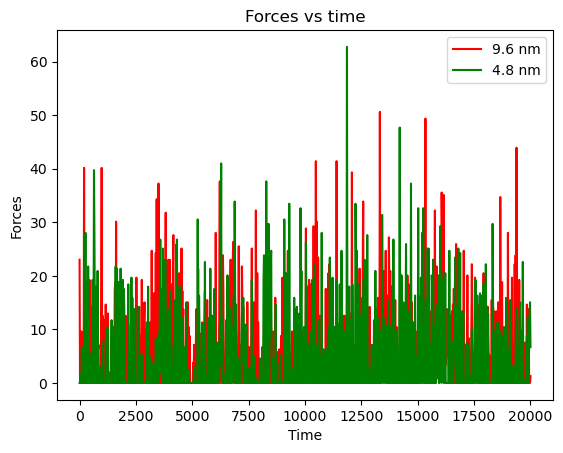

t0 = 0  g = 1.2628527  Neff_max = 793.4417


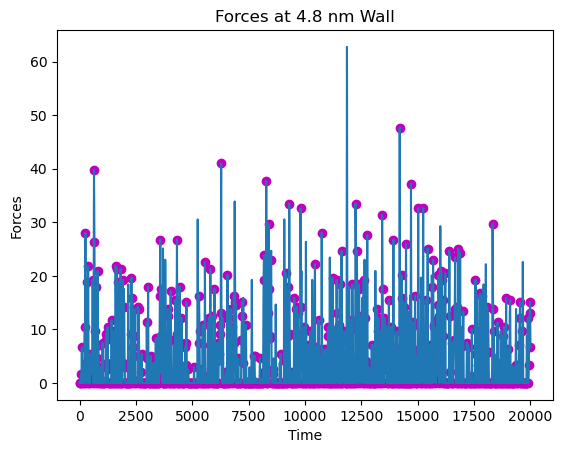

t0 = 0  g = 1.8204862  Neff_max = 550.4024


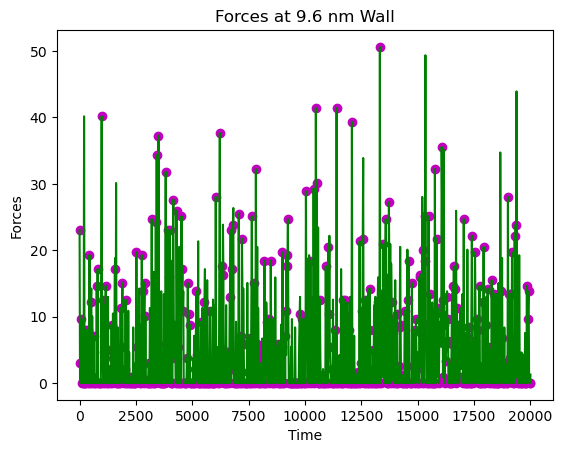

----------------------------------------------------------------
---Wall 4.8 nm---
t0 = 0  g = 1.2628527  Neff_max = 793.4417
Mean = 4.818444512945551 kJ/(A mol), std error = 0.2812159768464377, variance = 0.07908242563369618 

---Wall 9.6 nm---
t0 = 0  g = 1.8204862  Neff_max = 550.4024
Mean = 5.304747068117429 kJ/(A mol), std error = 0.35322478992100165, variance = 0.12476775221473575 

---Statistical Analysis results---
Mean force between two walls: 5.06159579053149 kJ/(A mol)
Mean std error between two walls: +/-0.3127072342754733 or 0.31925708907433203
------------------------------------------------------------------------
FINAL STATISTICAL RESULTS:
------------------------------------------------------------------------
Osmotic Pressure = 36.47993729349057 bar +/- 2.3009499517366705 bar 
Osmotic Coefficient = 0.7492554412327026 +/- 0.04725883319022187


In [10]:
ori=SPW_analysis(u,ions,0)


Data for replicate # 1
mean forces = {48: Quantity(value=5.322948476999076, unit=kilojoule/(angstrom*mole)), 96: Quantity(value=4.905556893058133, unit=kilojoule/(angstrom*mole))}
48
Osmotic Pressure Observed: 38.36355858771915 bar
Osmotic Pressure Ideal: 48.688251410590276 bar
Osmotic Coefficient: 0.7879428296612562
96
Osmotic Pressure Observed: 35.355333624856705 bar
Osmotic Pressure Ideal: 48.688251410590276 bar
Osmotic Coefficient: 0.7261573911682213

Average between 2 walls: 
Osmotic Pressure Observed: 36.859446106287926 bar
Osmotic Pressure Ideal: 48.688251410590276 bar
Osmotic Coefficient: 0.7570501104147388


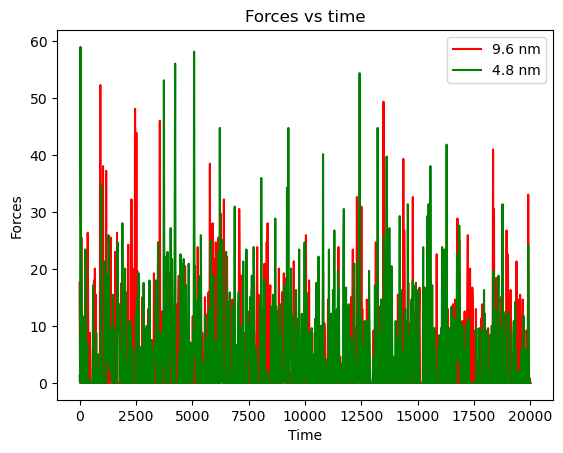

t0 = 0  g = 1.1083744  Neff_max = 904.0267


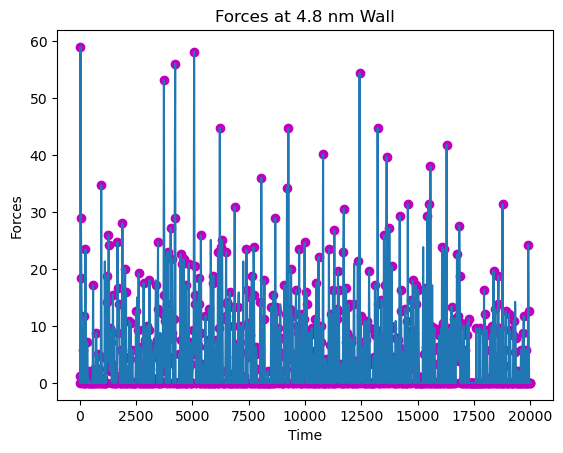

t0 = 0  g = 2.3211994  Neff_max = 431.67337


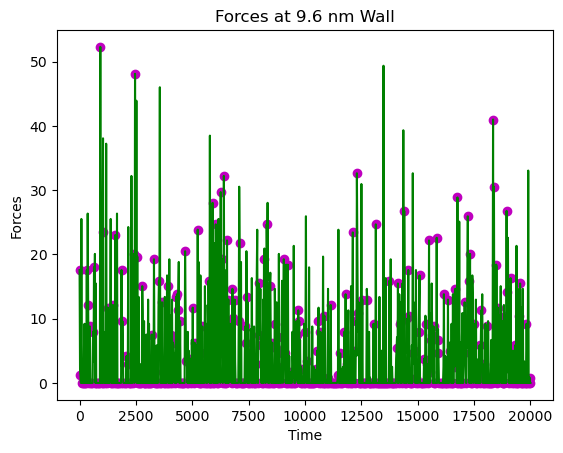

----------------------------------------------------------------
---Wall 4.8 nm---
t0 = 0  g = 1.1083744  Neff_max = 904.0267
Mean = 5.322948476999075 kJ/(A mol), std error = 0.28679846528538044, variance = 0.08225335969004957 

---Wall 9.6 nm---
t0 = 0  g = 2.3211994  Neff_max = 431.67337
Mean = 4.9055568930581135 kJ/(A mol), std error = 0.38823287967034115, variance = 0.1507247688571256 

---Statistical Analysis results---
Mean force between two walls: 5.114252685028594 kJ/(A mol)
Mean std error between two walls: +/-0.32309793783424645 or 0.3413049432305187
------------------------------------------------------------------------
FINAL STATISTICAL RESULTS:
------------------------------------------------------------------------
Osmotic Pressure = 36.85944610628785 bar +/- 2.459853264122518 bar 
Osmotic Coefficient = 0.7570501104147371 +/- 0.05052252222776418


In [11]:
r1=SPW_analysis(u1,ions1,1)


Data for replicate # 2
mean forces = {48: Quantity(value=5.775197992010434, unit=kilojoule/(angstrom*mole)), 96: Quantity(value=4.870028166413683, unit=kilojoule/(angstrom*mole))}
48
Osmotic Pressure Observed: 41.62301165971041 bar
Osmotic Pressure Ideal: 48.688251410590276 bar
Osmotic Coefficient: 0.8548882010302984
96
Osmotic Pressure Observed: 35.099270957321764 bar
Osmotic Pressure Ideal: 48.688251410590276 bar
Osmotic Coefficient: 0.7208981620910554

Average between 2 walls: 
Osmotic Pressure Observed: 38.36114130851609 bar
Osmotic Pressure Ideal: 48.688251410590276 bar
Osmotic Coefficient: 0.787893181560677


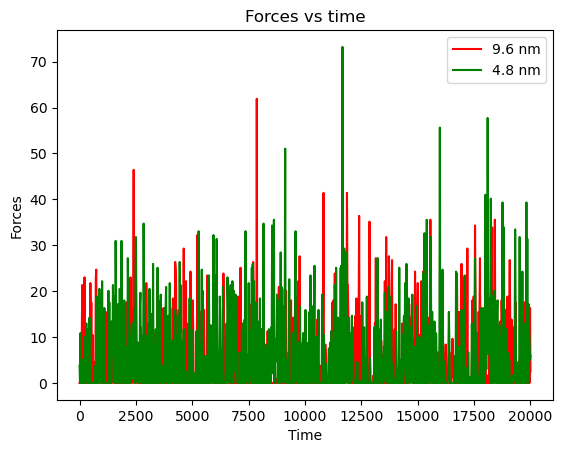

t0 = 100  g = 2.2883437  Neff_max = 394.17157


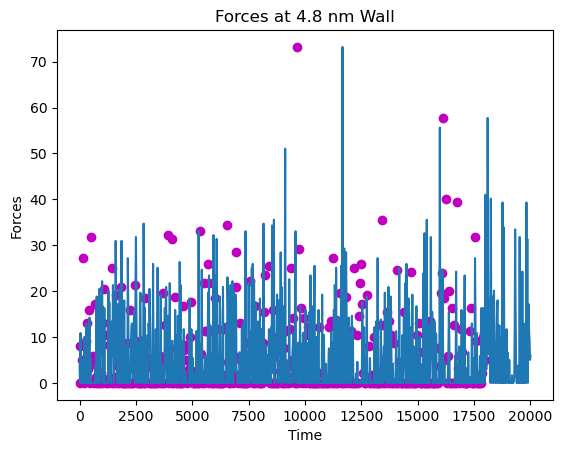

t0 = 0  g = 1.7293384  Neff_max = 579.41235


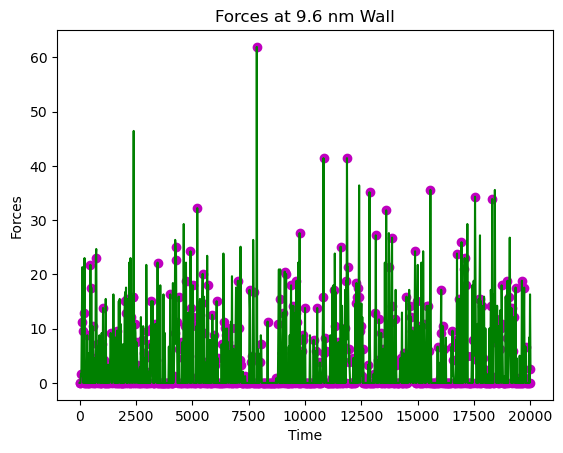

----------------------------------------------------------------
---Wall 4.8 nm---
t0 = 100  g = 2.2883437  Neff_max = 394.17157
Mean = 5.775197992010432 kJ/(A mol), std error = 0.44840036587932164, variance = 0.20106288812070952 

---Wall 9.6 nm---
t0 = 0  g = 1.7293384  Neff_max = 579.41235
Mean = 4.8700281664136655 kJ/(A mol), std error = 0.3245823386943259, variance = 0.1053536945922781 

---Statistical Analysis results---
Mean force between two walls: 5.322613079212049 kJ/(A mol)
Mean std error between two walls: +/-0.37959291776735027 or 0.3914183073854541
------------------------------------------------------------------------
FINAL STATISTICAL RESULTS:
------------------------------------------------------------------------
Osmotic Pressure = 38.36114130851602 bar +/- 2.821030342971388 bar 
Osmotic Coefficient = 0.7878931815606756 +/- 0.05794067893672149


In [12]:
r2=SPW_analysis(u2,ions2,2)


Data for replicate # 3
mean forces = {48: Quantity(value=4.224077859091583, unit=kilojoule/(angstrom*mole)), 96: Quantity(value=5.720636816186769, unit=kilojoule/(angstrom*mole))}
48
Osmotic Pressure Observed: 30.443777377628628 bar
Osmotic Pressure Ideal: 48.688251410590276 bar
Osmotic Coefficient: 0.6252797439960381
96
Osmotic Pressure Observed: 41.22977830898932 bar
Osmotic Pressure Ideal: 48.688251410590276 bar
Osmotic Coefficient: 0.846811645817729

Average between 2 walls: 
Osmotic Pressure Observed: 35.83677784330897 bar
Osmotic Pressure Ideal: 48.688251410590276 bar
Osmotic Coefficient: 0.7360456949068837


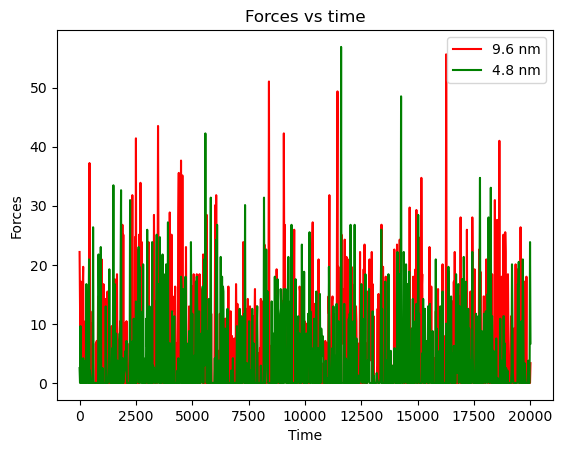

t0 = 0  g = 1.088297  Neff_max = 920.7045


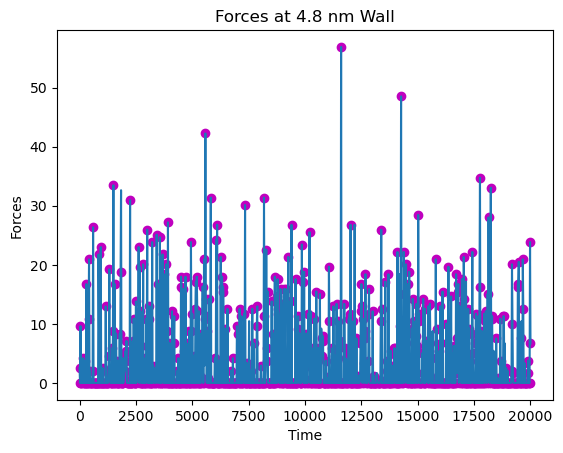

t0 = 0  g = 1.5068835  Neff_max = 664.94855


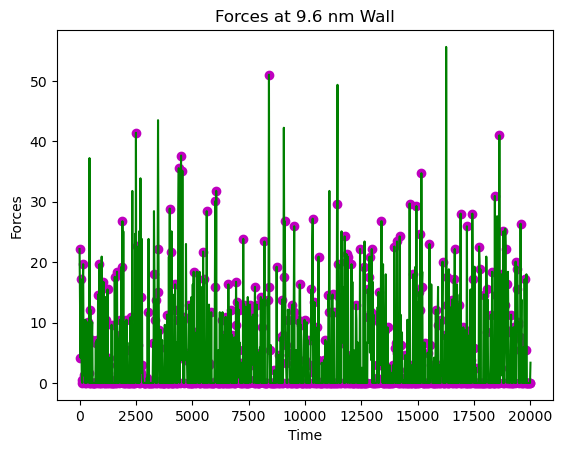

----------------------------------------------------------------
---Wall 4.8 nm---
t0 = 0  g = 1.088297  Neff_max = 920.7045
Mean = 4.224077859091592 kJ/(A mol), std error = 0.23928463726692184, variance = 0.05725713763196236 

---Wall 9.6 nm---
t0 = 0  g = 1.5068835  Neff_max = 664.94855
Mean = 5.720636816186744 kJ/(A mol), std error = 0.33496685711505486, variance = 0.11220279536553758 

---Statistical Analysis results---
Mean force between two walls: 4.972357337639168 kJ/(A mol)
Mean std error between two walls: +/-0.2833448431389821 or 0.2910841227184162
------------------------------------------------------------------------
FINAL STATISTICAL RESULTS:
------------------------------------------------------------------------
Osmotic Pressure = 35.836777843308916 bar +/- 2.097901725728977 bar 
Osmotic Coefficient = 0.7360456949068824 +/- 0.043088459021402827


In [13]:
r3=SPW_analysis(u3,ions3,3)

### Density profiles using GROMACS

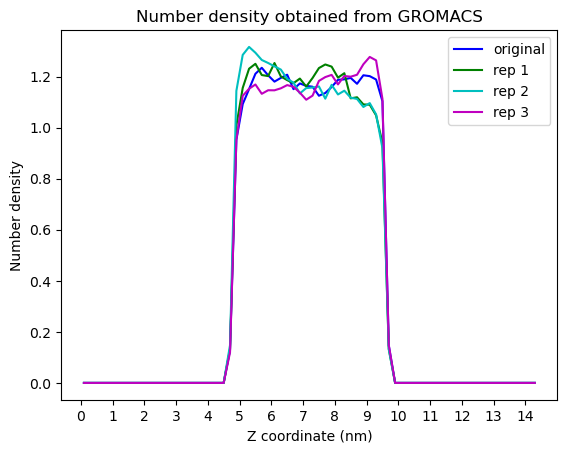

In [ ]:
x,y = np.loadtxt("density_original.xvg",comments=["@", "#"],unpack=True)
x1,y1 = np.loadtxt("dens_r1.xvg",comments=["@", "#"],unpack=True)
x2,y2 = np.loadtxt("dens_r2.xvg",comments=["@", "#"],unpack=True)
x3,y3 = np.loadtxt("dens_r3.xvg",comments=["@", "#"],unpack=True)
plt.plot(x,y, c='b', label='original')
plt.plot(x1,y1, c='g', label='rep 1')
plt.plot(x2,y2, c='c', label='rep 2')
plt.plot(x3,y3, c='m', label='rep 3')
plt.xlabel("Z coordinate (nm)")
plt.ylabel("Number density")
plt.xticks(np.arange(0, 14.4, 1.0))
plt.title('Number density obtained from GROMACS')
plt.legend()
#plt.savefig("volume.png", format="png", dpi=300)
plt.show()

## Density profiles using MDanalysis

[0.       0.       0.       0.       0.       0.       0.       0.
 0.       0.       0.       0.       0.       0.       0.       0.
 0.       0.       0.       0.       0.       0.       0.       0.128127
 0.952173 1.09222  1.15098  1.21103  1.23444  1.20496  1.18024  1.19477
 1.20734  1.15076  1.17309  1.16355  1.1603   1.12496  1.13558  1.15921
 1.1874   1.18913  1.19477  1.17179  1.20518  1.20171  1.18848  1.1035
 0.146121 0.       0.       0.       0.       0.       0.       0.
 0.       0.       0.       0.       0.       0.       0.       0.
 0.       0.       0.       0.       0.       0.       0.       0.      ]
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


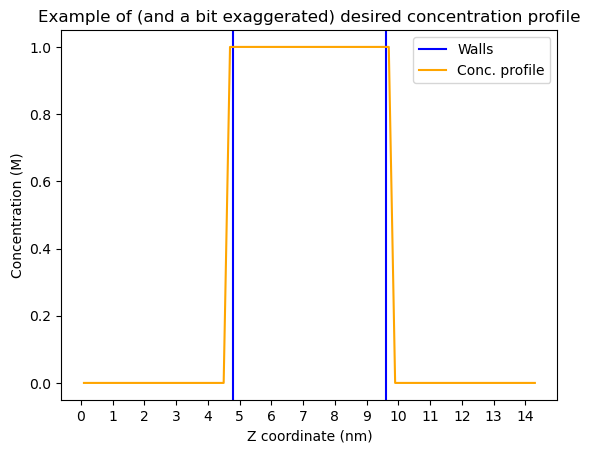

In [ ]:
xfak,yfak = np.loadtxt("density_original.xvg",comments=["@", "#"],unpack=True)
print(yfak)
yfak2=[]
for i in yfak:
    if i != 0:
        i=1
        yfak2.append(i)
    else:
        yfak2.append(i)

print(yfak2)
plt.axvline(x = 4.8, color = 'b', label = 'Walls')
plt.axvline(x = 9.6, color = 'b')
plt.plot(xfak,yfak2, c='orange', label = 'Conc. profile')
plt.xlabel("Z coordinate (nm)")
plt.ylabel("Concentration (M)")
plt.xticks(np.arange(0, 14.4, 1.0))
plt.title('Example of (and a bit exaggerated) desired concentration profile')
plt.legend()
#plt.savefig("volume.png", format="png", dpi=300)
plt.show()

In [ ]:
def density_profile(universe, atom_group, bin_width=0.5, dim='z', method='atom', frameby=1):
    '''Calculate the partial density across the box'''

    if isinstance(atom_group, str): # if provided selection language, make AtomGroup
        ag = universe.select_atoms(atom_group)
    else: # else assume input is AtomGroup
        ag = atom_group

    print(f'\nCalculating the partial density profile of {atom_group} in the {dim} dimension...')

    dims = {'x': 0, 'y': 1, 'z': 2}
    d = dims[dim]
    box = universe.dimensions[d]

    n_bins = int(box / bin_width)
    bins = np.linspace(0, box, num=n_bins)

    counts = np.zeros(n_bins-1)
        
    if len(universe.trajectory) == 0:
        for b in tqdm(range(n_bins-1)):
            lb = bins[b]
            ub = bins[b+1]
            bin_atoms = universe.select_atoms(f'prop {dim} > {lb} and prop {dim} < {ub} and group ag', ag=ag)
            if method in ['atom', 'atoms', 'all']:
                counts[b] += len(bin_atoms)
            elif method in ['molecule', 'mol', 'residue', 'res']: 
                counts[b] += bin_atoms.n_residues
            elif method in ['mass', 'mass density']:
                box_dims = [box[i] for i in range(3) if i != d]
                dV = box_dims[0] * box_dims[1] * (ub-lb) * (10**-8)**3
                mass = bin_atoms.masses.sum() / 6.022 / 10**23
                counts[b] += mass / dV
    else:
        for ts in tqdm(universe.trajectory[::frameby]):
            for b in range(n_bins-1):
                lb = bins[b]
                ub = bins[b+1]
                bin_atoms = universe.select_atoms(f'prop {dim} > {lb} and prop {dim} < {ub} and group ag', ag=ag)

                if method in ['atom', 'atoms', 'all', 'number']:
                    counts[b] += len(bin_atoms)                 
                elif method in ['molecule', 'mol', 'residue', 'res']: 
                    counts[b] += bin_atoms.n_residues
                elif method in ['mass', 'mass density']:
                    box_dims = [box[i] for i in range(3) if i != d]
                    dV = box_dims[0] * box_dims[1] * (ub-lb) * (10**-8)**3
                    mass = bin_atoms.masses.sum() / 6.022 / 10**23
                    counts[b] += mass / dV

        counts = counts / len(universe.trajectory[::frameby])

    return bins, counts

In [ ]:
nbins1_old,ncounts1_old=density_profile(u1,ions,2)


Calculating the partial density profile of <AtomGroup [<Atom 11101: NA of type NA of resname NA, resid 1 and segid SYSTEM>, <Atom 11102: NA of type NA of resname NA, resid 2 and segid SYSTEM>, <Atom 11103: NA of type NA of resname NA, resid 3 and segid SYSTEM>, ..., <Atom 11228: CL of type CL of resname CL, resid 63 and segid SYSTEM>, <Atom 11229: CL of type CL of resname CL, resid 64 and segid SYSTEM>, <Atom 11230: CL of type CL of resname CL, resid 65 and segid SYSTEM>]> in the z dimension...


100%|██████████| 1001/1001 [02:34<00:00,  6.49it/s]


In [ ]:
def density_fprofile(universe, atom_group, bin_width=0.5, dim='z', method='atom', frameby=1):
    '''Calculate the partial density across the box'''

    if isinstance(atom_group, str): # if provided selection language, make AtomGroup
        ag = universe.select_atoms(atom_group)
    else: # else assume input is AtomGroup
        ag = atom_group

    print(f'\nCalculating the partial density profile of {atom_group} in the {dim} dimension...')

    dims = {'x': 0, 'y': 1, 'z': 2}
    d = dims[dim]
    box = universe.dimensions[d]

    n_bins = int(box / bin_width)
    print(box,n_bins,bin_width)
    bins = np.linspace(0, box, num=n_bins)

    bin_atoms = universe.select_atoms(f'group ag', ag=ag)
    ion_indices = bin_atoms.indices
    nframes = len(universe.trajectory[::frameby])
    thisto = np.zeros([n_bins-1,nframes])
    ztraj = np.zeros([len(bin_atoms),nframes])    
    for i,ts in enumerate(tqdm(universe.trajectory[::frameby])):
        ztraj[:,i]= ts.positions[:,d][ion_indices]
        # calculate the histogram at each time point
        counts = np.histogram(ztraj[:,i],bins=bins)
        thisto[:,i] = counts[0]
    # we now have ztraj, get overall histogram
    counts = np.histogram(ztraj,bins=bins)
    return bins, counts[0], thisto

In [ ]:
newbins1,newcounts1,thisto1 = density_fprofile(u1,ions,bin_width=2.0,dim='z')


Calculating the partial density profile of <AtomGroup [<Atom 11101: NA of type NA of resname NA, resid 1 and segid SYSTEM>, <Atom 11102: NA of type NA of resname NA, resid 2 and segid SYSTEM>, <Atom 11103: NA of type NA of resname NA, resid 3 and segid SYSTEM>, ..., <Atom 11228: CL of type CL of resname CL, resid 63 and segid SYSTEM>, <Atom 11229: CL of type CL of resname CL, resid 64 and segid SYSTEM>, <Atom 11230: CL of type CL of resname CL, resid 65 and segid SYSTEM>]> in the z dimension...
144.0 72 2.0


100%|██████████| 1001/1001 [00:00<00:00, 12792.66it/s]


This new way of doing the counts is the same (it's the total counts, not counts per frame)

In [ ]:
newcounts1-ncounts1_old*1001

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0.])

Now find the statistical inefficiencies of the histogram time series.

In [ ]:
ncorrs = len(thisto1[:,0])
corrs = np.zeros(ncorrs)
for i in range(ncorrs):
    tsum = np.sum(thisto1[i])
    if tsum !=0:
        corrs[i] = timeseries.statistical_inefficiency(thisto1[i])

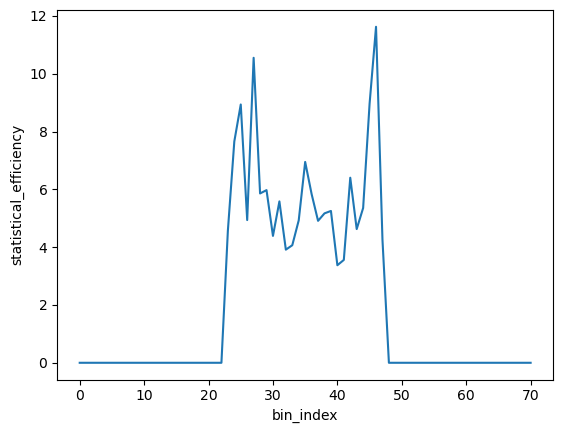

In [ ]:
plt.plot(corrs)
plt.ylabel('statistical_efficiency')
plt.xlabel('bin_index')
plt.show()

Now get all three replicate ncounts

In [ ]:
nbins1,ncounts1,thisto1=density_fprofile(u1,ions1,2)
nbins2,ncounts2,thisto2=density_fprofile(u2,ions2,2)
nbins3,ncounts3,thisto3=density_fprofile(u3,ions3,2)


Calculating the partial density profile of <AtomGroup [<Atom 11101: NA of type NA of resname NA, resid 1 and segid SYSTEM>, <Atom 11102: NA of type NA of resname NA, resid 2 and segid SYSTEM>, <Atom 11103: NA of type NA of resname NA, resid 3 and segid SYSTEM>, ..., <Atom 11228: CL of type CL of resname CL, resid 63 and segid SYSTEM>, <Atom 11229: CL of type CL of resname CL, resid 64 and segid SYSTEM>, <Atom 11230: CL of type CL of resname CL, resid 65 and segid SYSTEM>]> in the z dimension...
144.0 72 2


100%|██████████| 1001/1001 [00:00<00:00, 17647.57it/s]



Calculating the partial density profile of <AtomGroup [<Atom 11101: NA of type NA of resname NA, resid 1 and segid SYSTEM>, <Atom 11102: NA of type NA of resname NA, resid 2 and segid SYSTEM>, <Atom 11103: NA of type NA of resname NA, resid 3 and segid SYSTEM>, ..., <Atom 11228: CL of type CL of resname CL, resid 63 and segid SYSTEM>, <Atom 11229: CL of type CL of resname CL, resid 64 and segid SYSTEM>, <Atom 11230: CL of type CL of resname CL, resid 65 and segid SYSTEM>]> in the z dimension...
144.0 72 2


100%|██████████| 1001/1001 [00:00<00:00, 16428.75it/s]



Calculating the partial density profile of <AtomGroup [<Atom 11101: NA of type NA of resname NA, resid 1 and segid SYSTEM>, <Atom 11102: NA of type NA of resname NA, resid 2 and segid SYSTEM>, <Atom 11103: NA of type NA of resname NA, resid 3 and segid SYSTEM>, ..., <Atom 11228: CL of type CL of resname CL, resid 63 and segid SYSTEM>, <Atom 11229: CL of type CL of resname CL, resid 64 and segid SYSTEM>, <Atom 11230: CL of type CL of resname CL, resid 65 and segid SYSTEM>]> in the z dimension...
144.0 72 2


100%|██████████| 1001/1001 [00:00<00:00, 18255.21it/s]


### Effect of changing number of bins

There are 130 total ions in the system. About 25 bins in the middle are occupied. There are 1001 simulation frames, so we would expect somewhere around 5200 counts in each bin.

We can treat this as a multinomial problem, with p_i at each point. If each frame is uncorrelated, the expectation at each point is 1001$\times$130$\times p_i$ = ncounts. So we can approximate each $p_i$ as ncounts/(1001$\times$130).

In [ ]:
# https://en.wikipedia.org/wiki/Multinomial_distribution    
# total observations
# assume there is a multinomial distribution 
# with a probability of each bin being the observed probability 

nions = 130
nframes = 1001

In [ ]:
pi = ncounts1/(nions*1001) # since each ncounts is already divided by 1001

In [ ]:
np.sum(pi) # these probabilities are properly normalized

1.0

The variance in the number of counts will be $(1001 \times 130)(p_i)(1-p_i)$, so the standard deviation will be the square root of that.


In [ ]:
stds_multinomial = np.sqrt(nframes*nions*pi*(1-pi))
print(stds_multinomial)

[ 0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.         44.77849554
 69.57807126 73.18653124 74.74632424 74.04222456 73.15530241 74.22053907
 74.36772064 72.99265471 72.25531979 73.2738872  72.3630107  73.16154945
 72.96132658 74.78284061 74.4717623  73.72737826 73.79542281 71.91196819
 70.5904117  70.66857803 69.71713721 69.61121181 66.46709454 44.16834573
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.        ]


This is the standard deviation in the count number.  We should be seeing a count number of 5000 +/- 70. We are are interested in the standard deviation of the average count number, which we divide by nframes.

Note that this can be approximated for large numbers of bins by simply the square root of the number of bins.  Which turns out to be almost exactly the same!

In [ ]:
stds_simpler = np.sqrt(ncounts1)
print(stds_simpler)
print(stds_simpler/stds_multinomial)

[ 0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.         45.13313639
 70.96478    74.81310046 76.4852927  75.72978278 74.77967638 75.92101158
 76.07890641 74.60562981 73.81734214 74.90660852 73.93240156 74.78636239
 74.57211275 76.52450588 76.1905506  75.3923073  75.46522378 73.45066371
 72.04165462 72.12489168 71.11258679 71.         67.66830868 44.50842617
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.        ]
[       nan        nan        nan        nan        nan        nan
        nan        nan        nan        nan        nan        nan
        nan        nan        nan        nan     

/tmp/ipykernel_4093368/2294741754.py:3: RuntimeWarning: invalid value encountered in divide
  print(stds_simpler/stds_multinomial)


However, if we look at the variation between replicates, it's larger than this simple spread.

In [ ]:
replicates = np.vstack([ncounts1,ncounts2,ncounts3])
vals = np.mean(replicates,axis=0)
errs = np.std(replicates,axis=0,ddof=1) # std
print(vals)
print(errs)
# the variation in the replicates are much bigger

[   0.            0.            0.            0.            0.
    0.            0.            0.            0.            0.
    0.            0.            0.            0.            0.
    0.            0.            0.            0.            0.
    0.            0.            0.         2111.         5163.
 5696.66666667 5799.66666667 5707.         5589.         5673.
 5662.         5551.33333333 5451.33333333 5477.66666667 5363.
 5365.33333333 5465.33333333 5611.33333333 5568.         5534.33333333
 5529.66666667 5463.66666667 5309.         5328.33333333 5387.
 5385.         4866.66666667 2071.66666667    0.            0.
    0.            0.            0.            0.            0.
    0.            0.            0.            0.            0.
    0.            0.            0.            0.            0.
    0.            0.            0.            0.            0.
    0.        ]
[  0.           0.           0.           0.           0.
   0.           0.           0.     

One reason could be that we have fewer effective samples.  Thus, the fractional standard deviation should actually be larger by sqrt(ncorr).

In [ ]:
stds_corrected = stds_multinomial*np.sqrt(corrs)

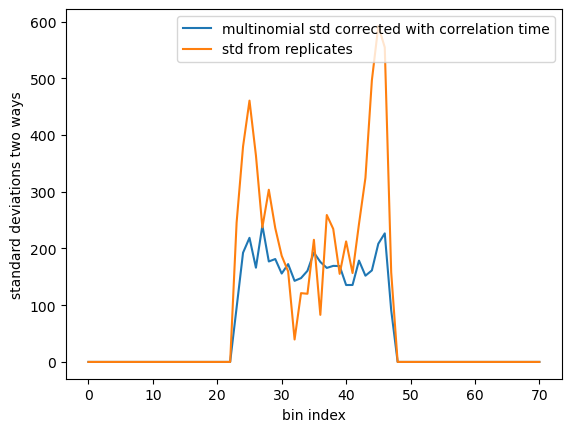

In [ ]:
plt.plot(stds_corrected,label='multinomial std corrected with correlation time')
plt.plot(errs,label='std from replicates')
plt.ylabel('standard deviations two ways')
plt.xlabel('bin index')
plt.legend()
plt.show()

This looks more reasonable!

In [ ]:
# turn it in to a function
def stdbycount(ncounts,thisto,nions=130,nframes=1001,):
    pi = ncounts/(nions*nframes)
    stds_multinomial = np.sqrt(nframes*nions*pi*(1-pi))
    ncorrs = len(thisto[:,0])
    corrs = np.zeros(ncorrs)
    for i in range(ncorrs):
        tsum = np.sum(thisto[i])
        if tsum !=0:
            corrs[i] = timeseries.statistical_inefficiency(thisto[i])
    return stds_multinomial*np.sqrt(corrs)

In [ ]:
std1 = stdbycount(ncounts1,thisto1)
std2 = stdbycount(ncounts2,thisto2)
std3 = stdbycount(ncounts3,thisto3)

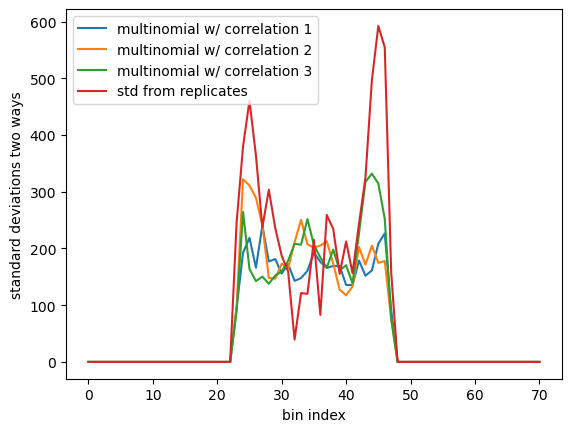

In [ ]:
# this doesn't look so bad - they MOSTLY agree.
plt.plot(std1,label='multinomial w/ correlation 1')
plt.plot(std2,label='multinomial w/ correlation 2')
plt.plot(std3,label='multinomial w/ correlation 3')
plt.plot(errs,label='std from replicates')
plt.ylabel('standard deviations two ways')
plt.xlabel('bin index')
plt.legend()
plt.show()

Theey generally look consistent; a bit noisy, but statistical inefficiency is noisy.

In [ ]:
# mean standard deviation from 3 replicates
stdall = np.sqrt((std1**2+std2**2+std3**2)/3)

nbinsn=nbins1/10

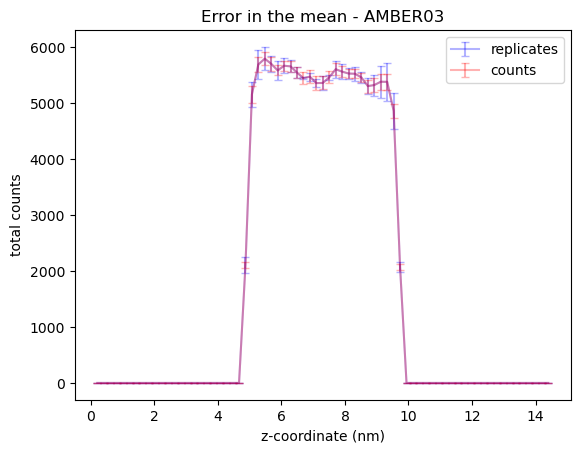

In [ ]:
replicates = np.vstack([ncounts1,ncounts2,ncounts3])
vals = np.mean(replicates,axis=0)
errs = np.std(replicates,axis=0,ddof=1)
# error in the mean,so divide by sqrt(3)
plt.errorbar(nbinsn[1:],vals,yerr=errs/np.sqrt(3),capsize=3,c='b',alpha=0.3,label='replicates')
plt.errorbar(nbinsn[1:],vals,yerr=stdall/np.sqrt(3),capsize=3,c='r',alpha=0.3,label='counts')
plt.ylabel('total counts')
plt.xlabel('z-coordinate (nm)')
plt.legend()
plt.title('Error in the mean - AMBER03')
plt.show()

When looking at the error in the mean over 3 replicates, the red and blue error bars look reasonably similar. The red bars a little lower, but the blue bars were from 3 replicates, so are pretty noisy. We thus conclude the amount of error is consistent.